In [1]:
# Mean Reversion and Momentum

In [13]:
import os
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


refs: 
- https://medium.com/call-for-atlas/pairs-trading-strategy-every-stock-needs-a-friend-e50723a1dc94
- https://github.com/adamd1985/quant_research/blob/main/pair-trading-quant.ipynb

### Simple Moving Average (SMA) Crossover
The Moving Average Crossover strategy involves calculating two or more moving averages for an asset's price: a short-term moving average (called a fast SMA) and a long-term moving average (slow SMA).
The code below implements this strategy:

In [14]:
def double_simple_moving_average_signals(ticker_ts_df, short_window=5, long_window=30):
    """
    Generate trading signals based on a double simple moving average (SMA) strategy.
    Parameters:
    - aapl_ts_df (pandas.DataFrame): A DataFrame containing historical stock data.
    - short_window (int): The window size for the short-term SMA.
    - long_window (int): The window size for the long-term SMA.
    Returns:
    - signals (pandas.DataFrame): A DataFrame containing the trading signals.
    """
    signals = pd.DataFrame(index=ticker_ts_df.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = ticker_ts_df['Close'].rolling(window=short_window,
                                                          min_periods=1,
                                                          center=False).mean()
    signals['long_mavg'] = ticker_ts_df['Close'].rolling(window=long_window,
                                                         min_periods=1,
                                                         center=False).mean()
    # Generate signal when SMAs cross
    signals['signal'] = np.where(
        signals['short_mavg'] > signals['long_mavg'], 1, 0)
    signals['orders'] = signals['signal'].diff()
    signals.loc[signals['orders'] == 0, 'orders'] = None
    return signals 

This function takes a timeseries of any stock, and sets a short (fast SMA) and long (slow SMA) rolling windonw, and compares the 2 across the timeline. When the fast SMA is higher, a buy signal is generated (1), and when it's lower, a sell signal is produced (-1).

We will create some utility functions to calculate our capital over the strategy's timeline, and a graphing function to help us visualize the entries and exit signals against the stock's timeseries.


In [15]:
def load_ticker_ts_df(ticker, start_date, end_date):
    """
    Load and cache time series financial data from Yahoo Finance API.
    Parameters:
    - ticker (str): The stock ticker symbol (e.g., 'AAPL' for Apple Inc.).
    - start_date (str): The start date in 'YYYY-MM-DD' format for data retrieval.
    - end_date (str): The end date in 'YYYY-MM-DD' format for data retrieval.
    Returns:
    - df (pandas.DataFrame): A DataFrame containing the financial time series data.

    """
    dir_path = './data'
    cached_file_path = f'{dir_path}/{ticker}_{start_date}_{end_date}.pkl'
    try:
        if os.path.exists(cached_file_path):
            df = pd.read_pickle(cached_file_path)
        else:
            df = yf.download(ticker, start=start_date, end=end_date)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            df.to_pickle(cached_file_path)
    except FileNotFoundError:
        print(
            f'Error downloading and caching or loading file with ticker: {ticker}')

    return df


def calculate_profit(signals, prices):
    """
    Calculate cumulative profit based on trading signals and stock prices.
    Parameters:
    - signals (pandas.DataFrame): A DataFrame containing trading signals (1 for buy, -1 for sell).
    - prices (pandas.Series): A Series containing stock prices corresponding to the signal dates.
    Returns:
    - cum_profit (pandas.Series): A Series containing cumulative profit over time.
    """
    profit = pd.DataFrame(index=prices.index)
    profit['profit'] = 0.0

    buys = signals[signals['orders'] == 1].index
    sells = signals[signals['orders'] == -1].index
    while sells[0] < buys[0]:
        # These are long only strategies, we cannot start with sell
        sells = sells[1:]

    if len(buys) == 0 or len(sells) == 0:
        # no actions taken
        return profit
    if len(sells) < len(buys):
        # Assume we sell at the end
        sells = sells.append(pd.Index(prices.tail(1).index))

    buy_prices = prices.loc[buys]
    sell_prices = prices.loc[sells]

    profit.loc[sells, 'profit'] = sell_prices.values - buy_prices.values
    profit['profit'] = profit['profit'].fillna(0)

    # Make profit cumulative
    profit['cum_profit'] = profit['profit'].cumsum()

    return profit['cum_profit']


def plot_strategy(prices_df, signal_df, profit):
    """
    Plot a trading strategy with buy and sell signals and cumulative profit.
    Parameters:
    - prices (pandas.Series): A Series containing stock prices.
    - signals (pandas.DataFrame): A DataFrame with buy (1) and sell (-1) signals.
    - profit (pandas.Series): A Series containing cumulative profit over time.
    Returns:
    - ax1 (matplotlib.axes.Axes): The top subplot displaying stock prices and signals.
    - ax2 (matplotlib.axes.Axes): The bottom subplot displaying cumulative profit.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': (3, 1)},
                                   figsize=(18, 12))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price in $')
    ax1.plot(prices_df.index, prices_df, color='g', lw=0.25)

    # Plot the Buy and Sell signals
    ax1.plot(signal_df.loc[signal_df.orders == 1.0].index,
             prices_df[signal_df.orders == 1.0],
             '^', markersize=12, color='blue', label='Buy')
    ax1.plot(signal_df.loc[signal_df.orders == -1.0].index,
             prices_df[signal_df.orders == -1.0],
             'v', markersize=12, color='red', label='Sell')

    ax2.plot(profit.index, profit, color='b')
    ax2.set_ylabel('Cumulative Profit (%)')
    ax2.set_xlabel('Date')

    return ax1, ax2 

[*********************100%%**********************]  1 of 1 completed


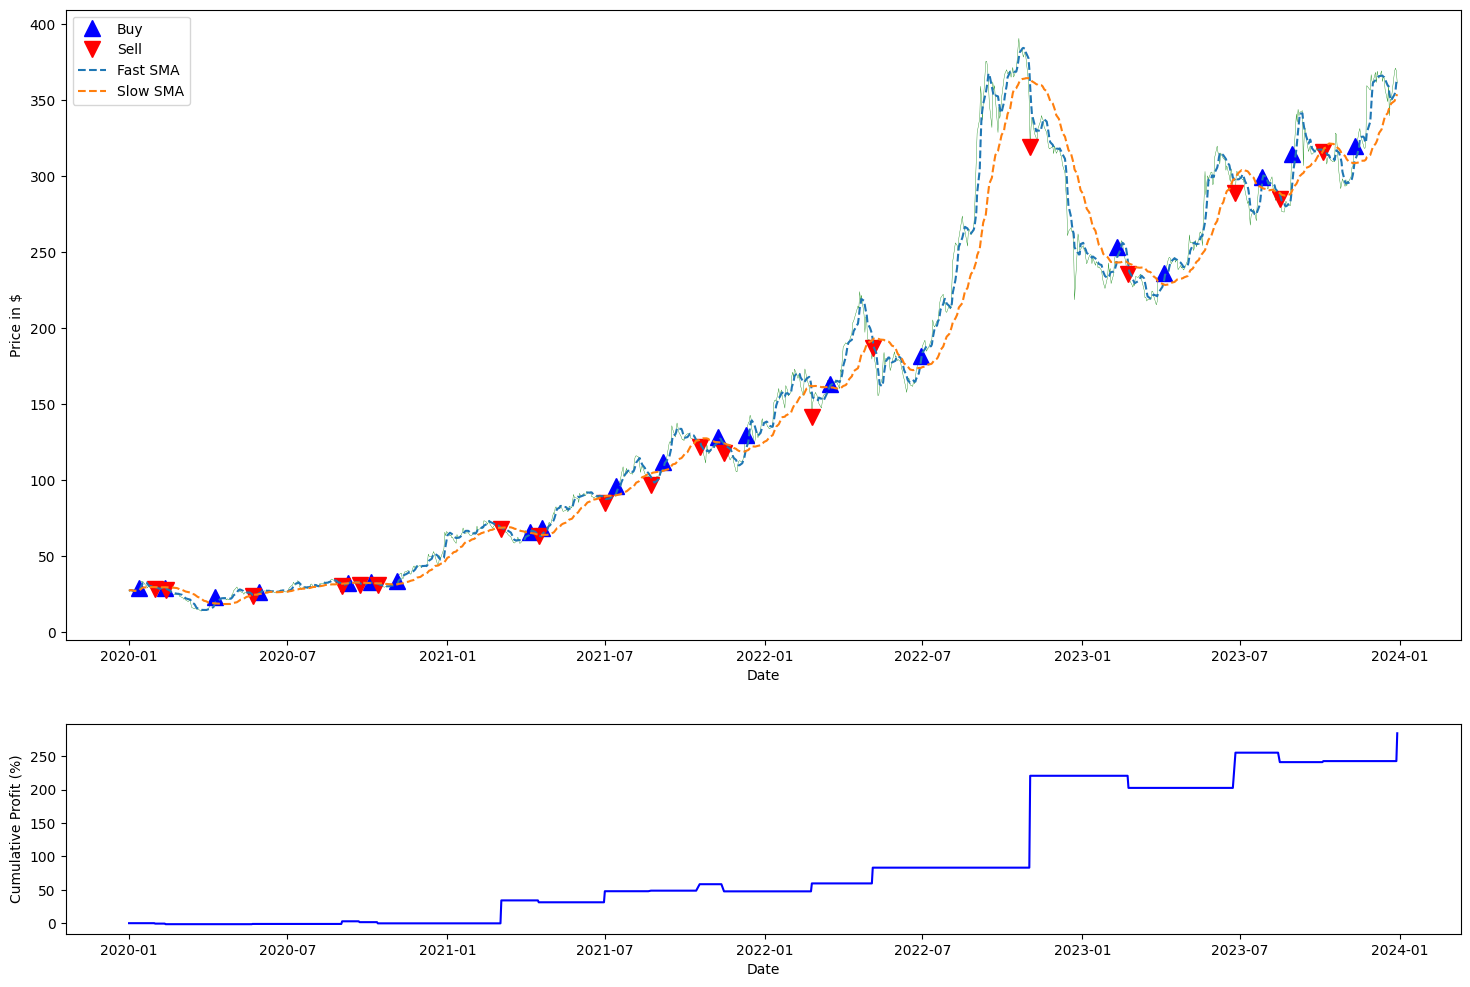

In [21]:
aapl_ts_df = load_ticker_ts_df('FCL.NS',
                               start_date='2020-01-01',
                               end_date='2024-01-01')
signal_df = double_simple_moving_average_signals(aapl_ts_df, 5, 30)
profit_series = calculate_profit(signal_df, aapl_ts_df["Adj Close"])
ax1, ax2 = plot_strategy(aapl_ts_df["Adj Close"], signal_df, profit_series)

# Add short and long moving averages
ax1.plot(signal_df.index, signal_df['short_mavg'],
         linestyle='--', label='Fast SMA')
ax1.plot(signal_df.index, signal_df['long_mavg'],
         linestyle='--', label='Slow SMA')
ax1.legend(loc='upper left', fontsize=10)
plt.show() 

### Throughout 2 years, this strategy gave us 200% return. 


[*********************100%%**********************]  1 of 1 completed


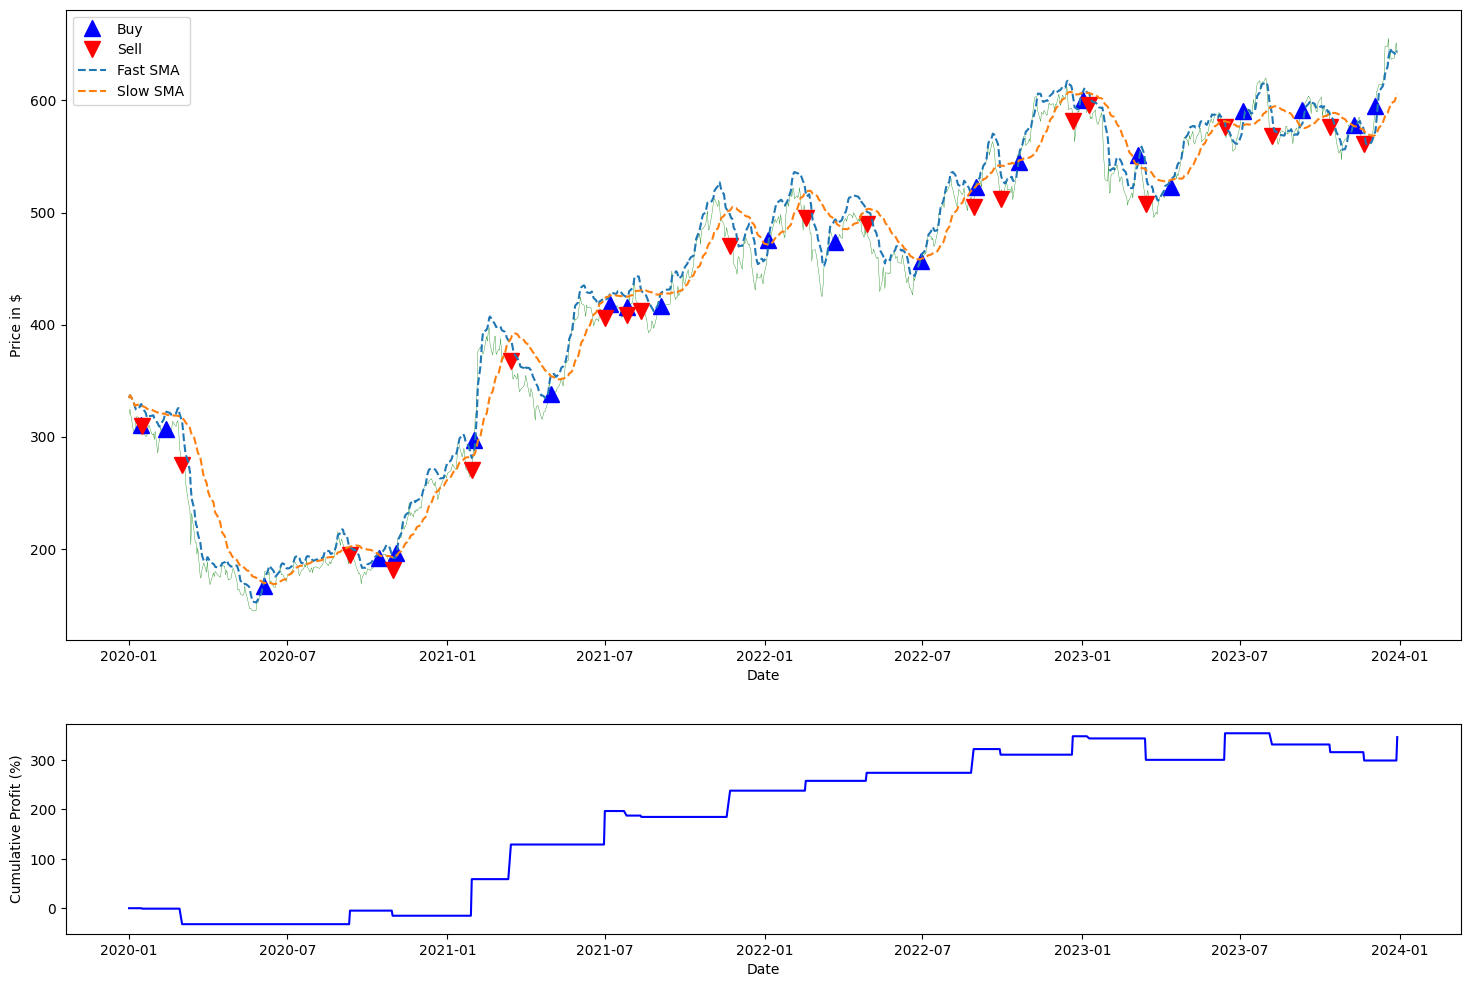

In [20]:
aapl_ts_df = load_ticker_ts_df('SBIN.NS',
                               start_date='2020-01-01',
                               end_date='2024-01-01')
signal_df = double_simple_moving_average_signals(aapl_ts_df, 5, 30)
profit_series = calculate_profit(signal_df, aapl_ts_df["Adj Close"])
ax1, ax2 = plot_strategy(aapl_ts_df["Adj Close"], signal_df, profit_series)

# Add short and long moving averages
ax1.plot(signal_df.index, signal_df['short_mavg'],
         linestyle='--', label='Fast SMA')
ax1.plot(signal_df.index, signal_df['long_mavg'],
         linestyle='--', label='Slow SMA')
ax1.legend(loc='upper left', fontsize=10)
plt.show() 

#### SBI Bank is giving consistent profit of more than 110% percent from 2021 to 2024

# Naive Momentum
This strategy is based on the number of times a price increases or decreases. It assumes that when a price increases for a certain number of consecutive days, it's a signal to buy, and when it decreases, it's a signal to sell. 

Date
2020-01-01     26.609951
2020-01-02     27.450787
2020-01-03     27.351866
2020-01-06     25.868040
2020-01-07     25.868040
                 ...    
2023-12-22    349.850006
2023-12-26    369.399994
2023-12-27    371.200012
2023-12-28    369.350006
2023-12-29    361.299988
Name: Adj Close, Length: 992, dtype: float64


/tmp/ipykernel_12236/4068856877.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if price_diff[i] > 0:
/tmp/ipykernel_12236/4068856877.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cons_day = cons_day + 1 if price_diff[i] > 0 else 0
/tmp/ipykernel_12236/4068856877.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif price_diff[i] < 0:
/tmp/ipykernel_12236/4068856877.py:27: FutureWarning: Series.__getitem__ treating k

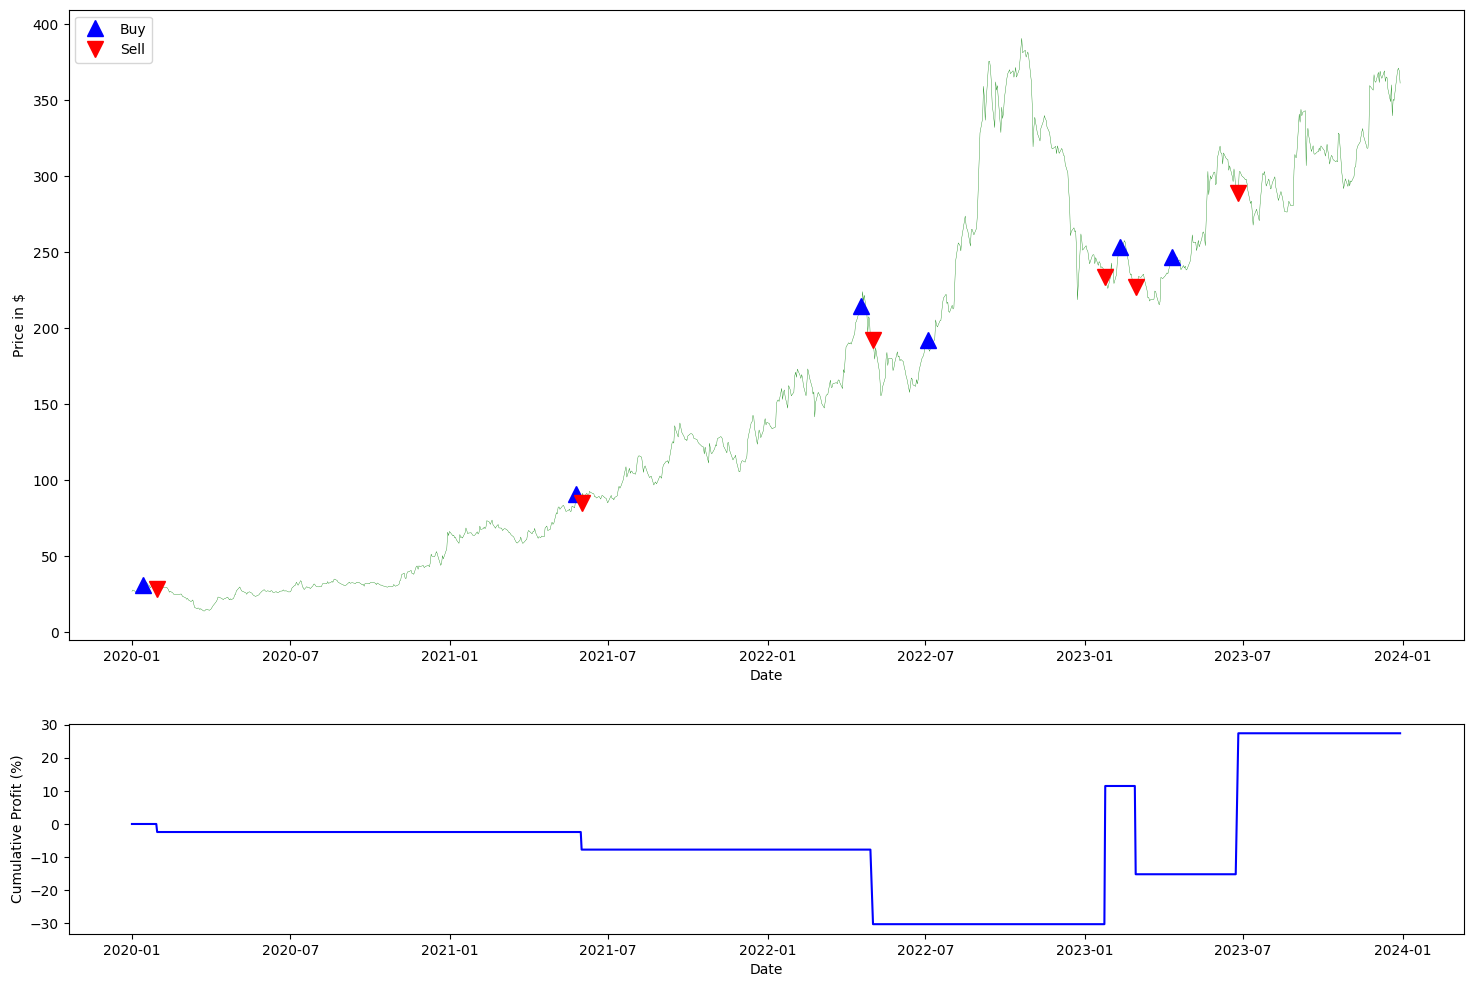

In [24]:
def naive_momentum_signals(ticker_ts_df, nb_conseq_days=2):
    """
    Generate naive momentum trading signals based on consecutive positive or negative price changes.
    Parameters:
    - ticker_ts_df (pandas.DataFrame): A DataFrame containing historical stock data.
    - nb_conseq_days (int): The number of consecutive positive or negative days to trigger a signal.
    Returns:
    - signals (pandas.DataFrame): A DataFrame with 'orders' column containing buy (1) and sell (-1) signals.
    """
    signals = pd.DataFrame(index=ticker_ts_df.index)
    signals['orders'] = 0

    price = ticker_ts_df['Adj Close']
    print(price)
    price_diff = price.diff()

    signal = 0
    cons_day = 0

    for i in range(1, len(ticker_ts_df)):
        if price_diff[i] > 0:
            cons_day = cons_day + 1 if price_diff[i] > 0 else 0
            if cons_day == nb_conseq_days and signal != 1:
                signals['orders'].iloc[i] = 1
                signal = 1
        elif price_diff[i] < 0:
            cons_day = cons_day - 1 if price_diff[i] < 0 else 0
            if cons_day == -nb_conseq_days and signal != -1:
                signals['orders'].iloc[i] = -1
                signal = -1

    return signals


signal_df = naive_momentum_signals(aapl_ts_df)
profit_series = calculate_profit(signal_df, aapl_ts_df["Adj Close"])
ax1, _ = plot_strategy(aapl_ts_df["Adj Close"], signal_df, profit_series)

ax1.legend(loc='upper left', fontsize=10)
plt.show() 


This strategy is a losing one, it didn't give us any returns. 
We would have done better inversing this model (just like you ought to do with most of WSB's stock analysis). Hint to achieve this: signals['orders'] = signals['orders'] * -1

# Reversion Strategies

An example: Elon tweets that he will install blockchain in teslas, the market gets overzelous in its buying of Tesla stock. 
The next day, everyone realizes that fundamentally nothing has changed, so the market loses interest and the price reverts back to an acceptable level.
Therefore, any instrument that d
ivereges too fast from a benchmark in either direction, will eventually revert back to the benchmark in the longer timeframe.
Just like trends and momentum - this is a simple strategy, it smooths everything and is gernerally used by all market participants.

## Mean Reversion


In [25]:
def mean_reversion_signals(ticker_ts_df, entry_threshold=1.0, exit_threshold=0.5):
    """
    Generate mean reversion trading signals based on moving averages and thresholds.
    Parameters:
    - ticker_ts_df (pandas.DataFrame): A DataFrame containing historical stock data.
    - entry_threshold (float): The entry threshold as a multiple of the standard deviation.
    - exit_threshold (float): The exit threshold as a multiple of the standard deviation.

    Returns:
    - signals (pandas.DataFrame): A DataFrame with 'orders' column containing buy (1) and sell (-1) signals.

    """
    signals = pd.DataFrame(index=ticker_ts_df.index)
    signals['mean'] = ticker_ts_df['Adj Close'].rolling(
        window=20).mean()  # Adjust the window size as needed
    signals['std'] = ticker_ts_df['Adj Close'].rolling(
        window=20).std()  # Adjust the window size as needed

    signals['signal'] = np.where(ticker_ts_df['Adj Close'] > (
        signals['mean'] + entry_threshold * signals['std']), 1, 0)
    signals['signal'] = np.where(ticker_ts_df['Adj Close'] < (
        signals['mean'] - exit_threshold * signals['std']), -1, 0)

    signals['orders'] = signals['signal'].diff()
    signals.loc[signals['orders'] == 0, 'orders'] = None

    return signals

In this function, we find the standard deviation and the mean.
if the price diverges from its mean by a standard deviaion and a factor, it will generate a signal.

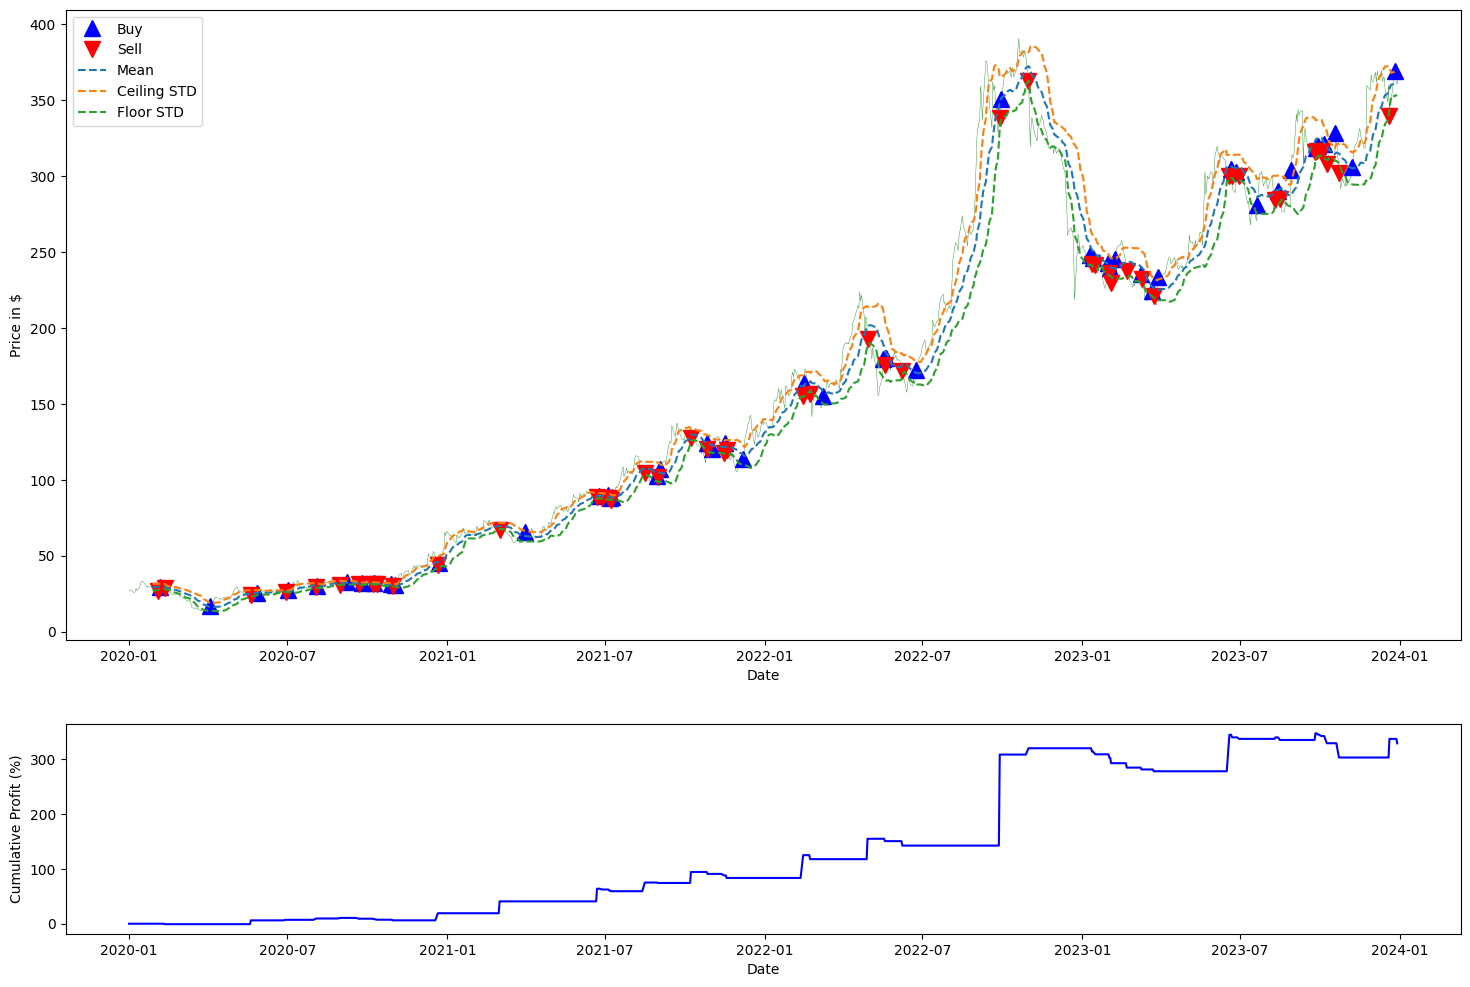

In [26]:
signal_df = mean_reversion_signals(aapl_ts_df)
profit_series = calculate_profit(signal_df, aapl_ts_df["Adj Close"])
ax1, _ = plot_strategy(aapl_ts_df["Adj Close"], signal_df, profit_series)

ax1.plot(signal_df.index, signal_df['mean'], linestyle='--', label="Mean")
ax1.plot(signal_df.index, signal_df['mean'] +
         signal_df['std'], linestyle='--', label="Ceiling STD")
ax1.plot(signal_df.index, signal_df['mean'] -
         signal_df['std'], linestyle='--', label="Floor STD")
ax1.legend(loc='upper left', fontsize=10)
plt.show() 

In [40]:
smallcaps_stocks = ['AAVAS.NS', 'AEGISCHEM.NS', 'AFFLE.NS', 'ARE&M.NS', 'AMBER.NS', 'ANGELONE.NS', 'ANURAS.NS', 'APARINDS.NS', 'BLS.NS', 'BSE.NS', 'BALAMINES.NS', 'BALRAMCHIN.NS', 'BIKAJI.NS', 'BIRLACORPN.NS', 'BSOFT.NS', 'CESC.NS', 'CIEINDIA.NS', 'CAMPUS.NS', 'CANFINHOME.NS', 'CEATLTD.NS', 'CENTRALBK.NS', 'CDSL.NS', 'CENTURYTEX.NS', 'CHAMBLFERT.NS', 'CUB.NS', 'COCHINSHIP.NS', 'CAMS.NS', 'CREDITACC.NS', 'CYIENT.NS', 'DATAPATTNS.NS', 'DEEPAKFERT.NS', 'EASEMYTRIP.NS', 'ELGIEQUIP.NS', 'EQUITASBNK.NS', 'EXIDEIND.NS', 'FINCABLES.NS', 'FSL.NS', 'GLENMARK.NS', 'MEDANTA.NS', 'GRANULES.NS', 'GRAPHITE.NS', 'GNFC.NS', 'HFCL.NS', 'HAPPSTMNDS.NS', 'HINDCOPPER.NS', 'HUDCO.NS', 'IDBI.NS', 'IDFC.NS', 'IIFL.NS', 'IRB.NS', 'INDIAMART.NS', 'IEX.NS', 'IOB.NS', 'INTELLECT.NS', 'JBCHEPHARM.NS', 'JBMA.NS', 'JKLAKSHMI.NS', 'JUBLINGREA.NS', 'JYOTHYLAB.NS', 'KEI.NS', 'KRBL.NS', 'KALYANKJIL.NS', 'KARURVYSYA.NS', 'KEC.NS', 'LATENTVIEW.NS', 'LXCHEM.NS', 'MGL.NS', 'MANAPPURAM.NS', ]
bank_stocks = ['AUBANK.NS', 'AXISBANK.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'FEDERALBNK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'IDFCFIRSTB.NS', 'INDUSINDBK.NS', 'KOTAKBANK.NS', 'PNB.NS', 'SBIN.NS']
nifty_consumer = ['AMBER.NS', 'BATAINDIA.NS', 'BLUESTARCO.NS', 'CROMPTON.NS', 'DIXON.NS', 'HAVELLS.NS', 'KAJARIACER.NS', 'ORIENTELEC.NS', 'RAJESHEXPO.NS', 'RELAXO.NS', 'TTKPRESTIG.NS', 'TITAN.NS', 'VGUARD.NS', 'VOLTAS.NS', 'WHIRLPOOL.NS']

In [42]:
smallcaps_stocks = ['AAVAS.NS', 'AEGISCHEM.NS', 'AFFLE.NS', 'ARE&M.NS', 'AMBER.NS', 'ANGELONE.NS', 'ANURAS.NS', 'APARINDS.NS', 'BLS.NS', 'BSE.NS', 'BALAMINES.NS', 'BALRAMCHIN.NS', 'BIKAJI.NS', 'BIRLACORPN.NS', 'BSOFT.NS', 'CESC.NS', 'CIEINDIA.NS', 'CAMPUS.NS', 'CANFINHOME.NS', 'CEATLTD.NS', 'CENTRALBK.NS', 'CDSL.NS', 'CENTURYTEX.NS', 'CHAMBLFERT.NS', 'CUB.NS', 'COCHINSHIP.NS', 'CAMS.NS', 'CREDITACC.NS', 'CYIENT.NS', 'DATAPATTNS.NS', 'DEEPAKFERT.NS', 'EASEMYTRIP.NS', 'ELGIEQUIP.NS', 'EQUITASBNK.NS', 'EXIDEIND.NS', 'FINCABLES.NS', 'FSL.NS', 'GLENMARK.NS', 'MEDANTA.NS', 'GRANULES.NS', 'GRAPHITE.NS', 'GNFC.NS', 'HFCL.NS', 'HAPPSTMNDS.NS', 'HINDCOPPER.NS', 'HUDCO.NS', 'IDBI.NS', 'IDFC.NS', 'IIFL.NS', 'IRB.NS', 'INDIAMART.NS', 'IEX.NS', 'IOB.NS', 'INTELLECT.NS', 'JBCHEPHARM.NS', 'JBMA.NS', 'JKLAKSHMI.NS', 'JUBLINGREA.NS', 'JYOTHYLAB.NS', 'KEI.NS', 'KRBL.NS', 'KALYANKJIL.NS', 'KARURVYSYA.NS', 'KEC.NS', 'LATENTVIEW.NS', 'LXCHEM.NS', 'MGL.NS', 'MANAPPURAM.NS', ]
bank_stocks = ['AUBANK.NS', 'AXISBANK.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'FEDERALBNK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'IDFCFIRSTB.NS', 'INDUSINDBK.NS', 'KOTAKBANK.NS', 'PNB.NS', 'SBIN.NS']
nifty_consumer = ['AMBER.NS', 'BATAINDIA.NS', 'BLUESTARCO.NS', 'CROMPTON.NS', 'DIXON.NS', 'HAVELLS.NS', 'KAJARIACER.NS', 'ORIENTELEC.NS', 'RAJESHEXPO.NS', 'RELAXO.NS', 'TTKPRESTIG.NS', 'TITAN.NS', 'VGUARD.NS', 'VOLTAS.NS', 'WHIRLPOOL.NS']

START_DATE = '2020-01-01'
END_DATE = '2024-01-01'

universe_tickers = smallcaps_stocks + bank_stocks + nifty_consumer
universe_tickers_ts_map = {ticker: load_ticker_ts_df(
    ticker, START_DATE, END_DATE) for ticker in universe_tickers}


def sanitize_data(data_map):
    TS_DAYS_LENGTH = (pd.to_datetime(END_DATE) -
                      pd.to_datetime(START_DATE)).days
    data_sanitized = {}

    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
    for ticker, data in data_map.items():
        if data is None or len(data) < (TS_DAYS_LENGTH / 2):
            # We cannot handle shorter TSs
            continue

        if len(data) > TS_DAYS_LENGTH:
            # Normalize to have the same length (TS_DAYS_LENGTH)
            data = data[-TS_DAYS_LENGTH:]

        # Reindex the time series to match the date range and fill in any blanks (Not Numbers)
        data = data.reindex(date_range)
        data['Adj Close'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['Adj Close'].interpolate(method='linear', inplace=True)
        data['Adj Close'].fillna(method='pad', inplace=True)
        data['Adj Close'].fillna(method='bfill', inplace=True)

        assert not np.any(np.isnan(data['Adj Close'])) and not np.any(
            np.isinf(data['Adj Close']))

        data_sanitized[ticker] = data

    return data_sanitized


# Sample some
uts_sanitized = sanitize_data(universe_tickers_ts_map)
uts_sanitized['HDFCBANK.NS'].shape, uts_sanitized['AAVAS.NS'].shape

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

((1462, 6), (1462, 6))

In [43]:
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint


def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    """
    Find cointegrated pairs of stocks based on the Augmented Dickey-Fuller (ADF) test.
    Parameters:
    - tickers_ts_map (dict): A dictionary where keys are stock tickers and values are time series data.
    - p_value_threshold (float): The significance level for cointegration testing.
    Returns:
    - pvalue_matrix (numpy.ndarray): A matrix of cointegration p-values between stock pairs.
    - pairs (list): A list of tuples representing cointegrated stock pairs and their p-values.
    """
    tickers = list(tickers_ts_map.keys())
    n = len(tickers)

    # Extract 'Adj Close' prices into a matrix (each column is a time series)
    adj_close_data = np.column_stack(
        [tickers_ts_map[ticker]['Adj Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))

    # Calculate cointegration p-values for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = coint(adj_close_data[:, i], adj_close_data[:, j])
        pvalue_matrix[i, j] = result[1]
    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j])
             for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]

    return pvalue_matrix, pairs


# This section can take up to 5mins
P_VALUE_THRESHOLD = 0.02
pvalues, pairs = find_cointegrated_pairs(
    uts_sanitized, p_value_threshold=P_VALUE_THRESHOLD)

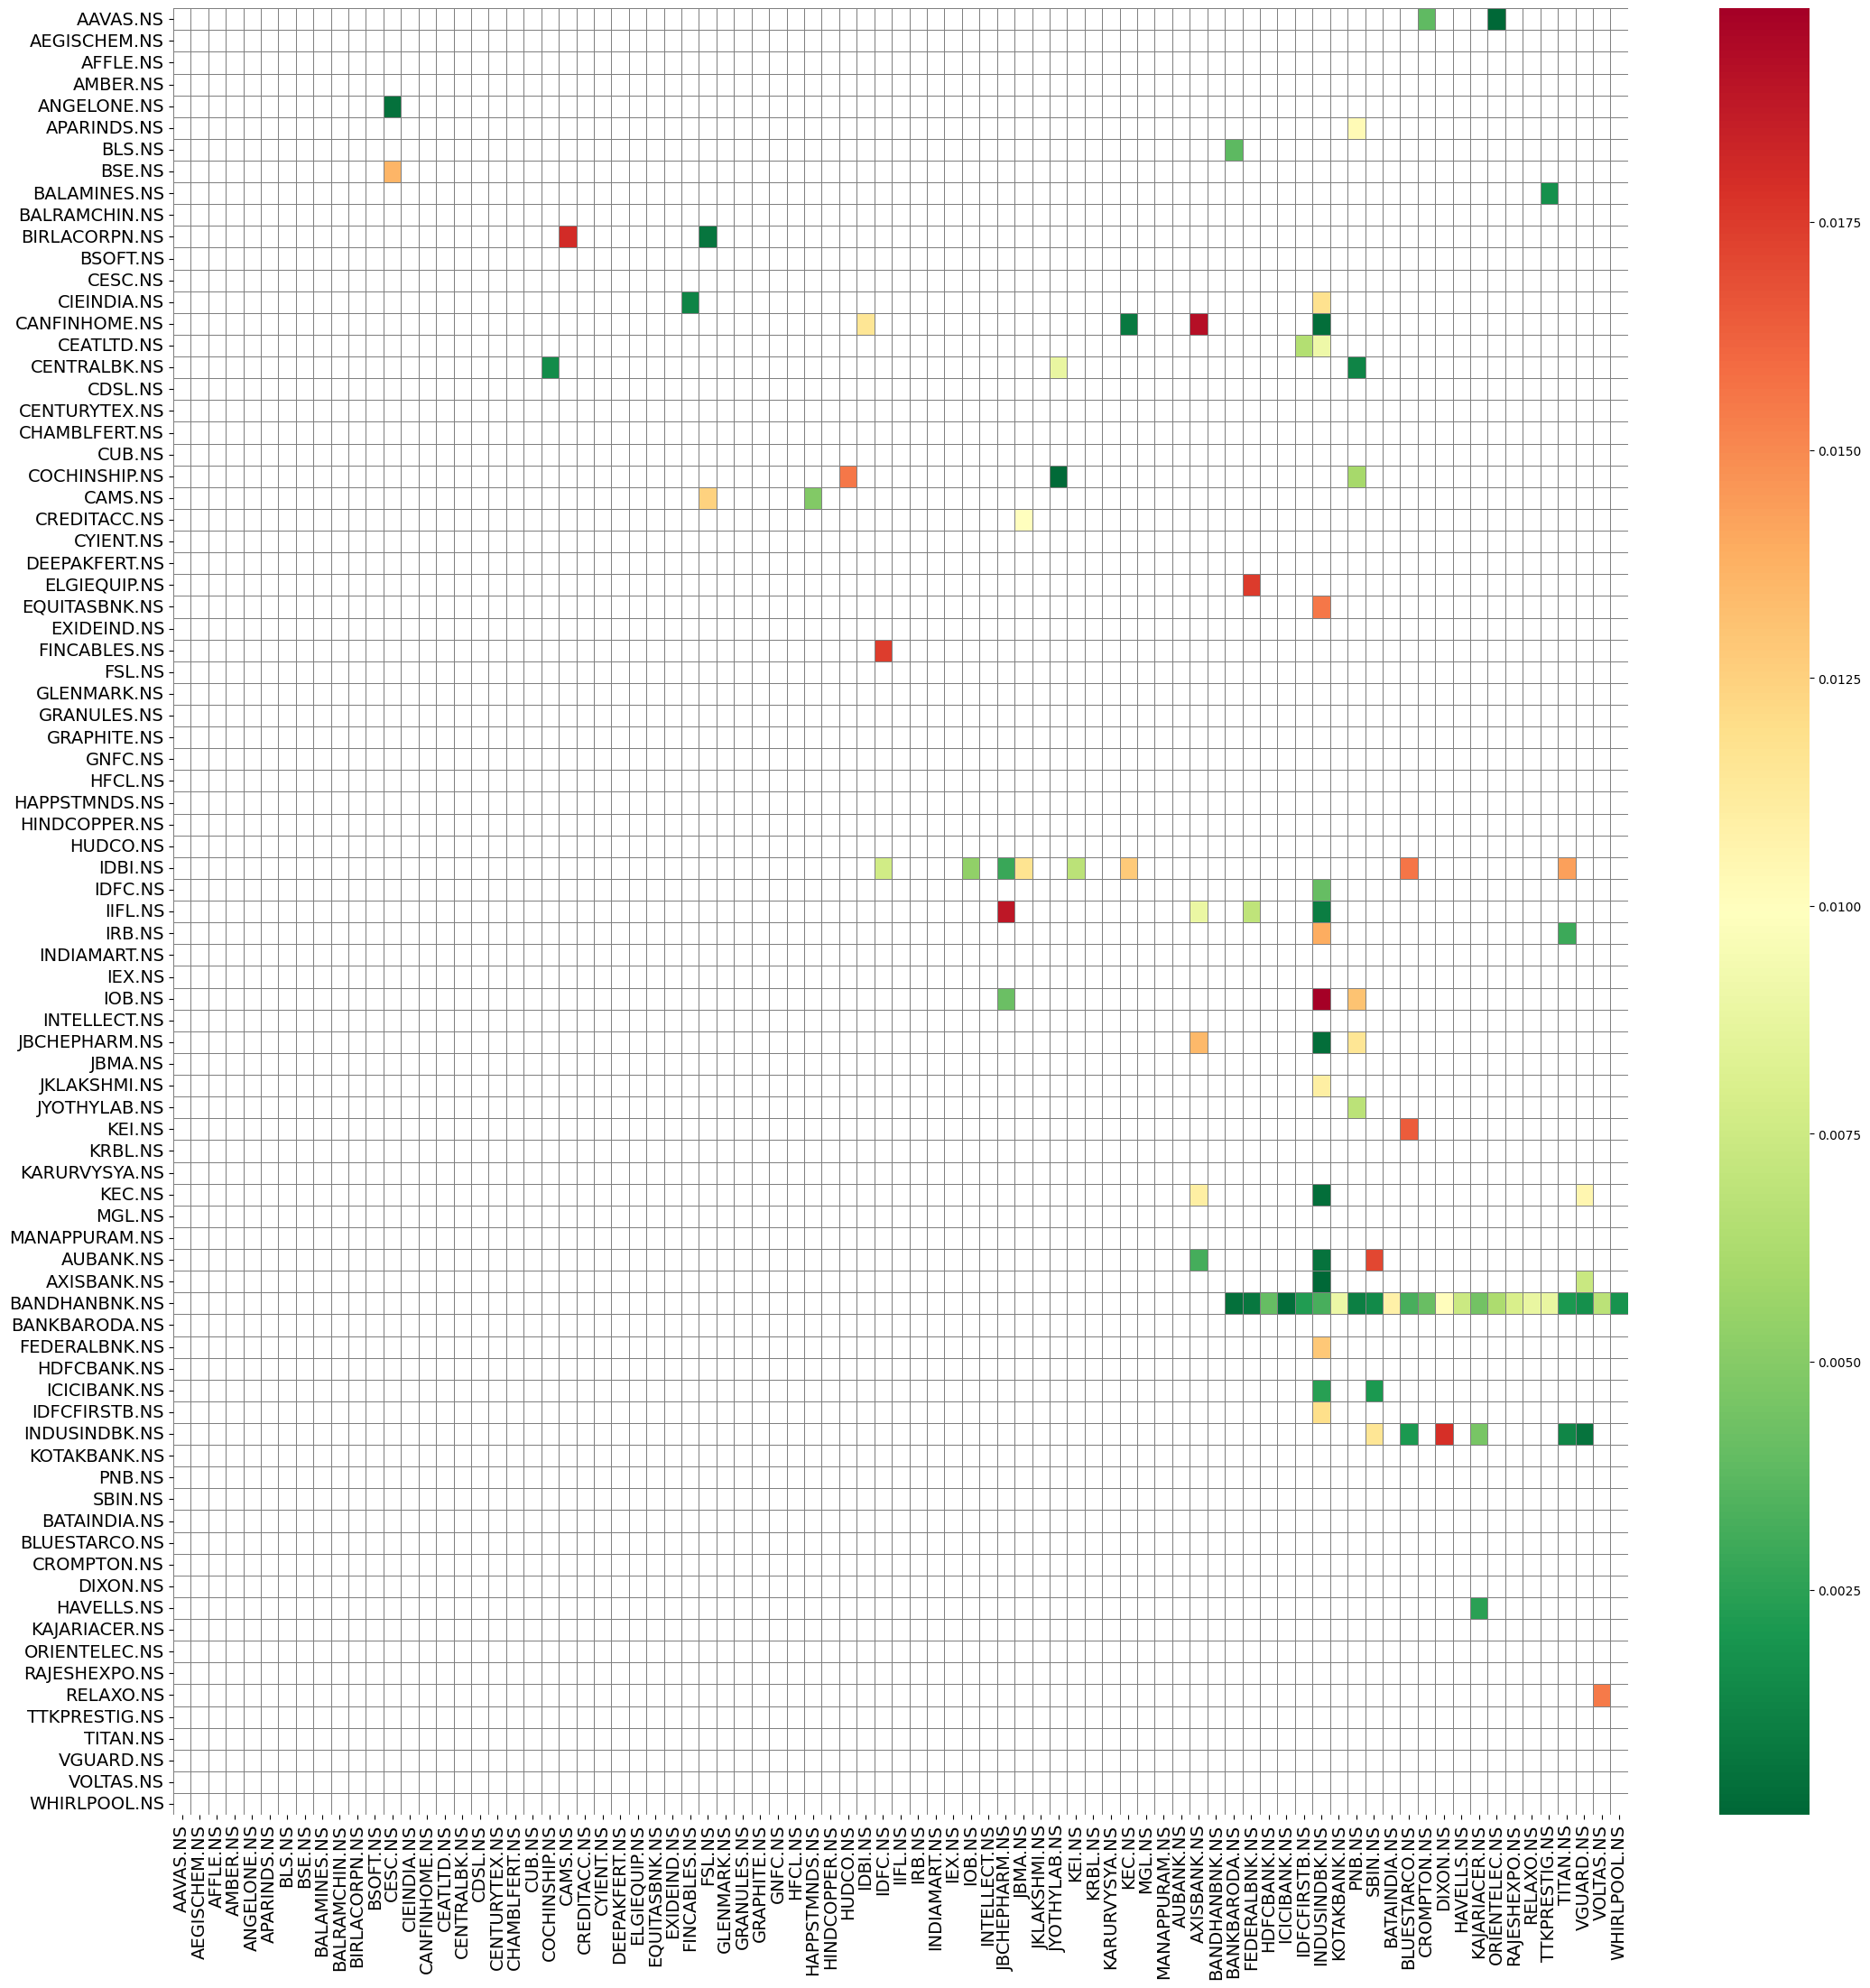

In [45]:
import seaborn as sns

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=uts_sanitized.keys(),
                      yticklabels=uts_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(pvalues > (P_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
plt.show()

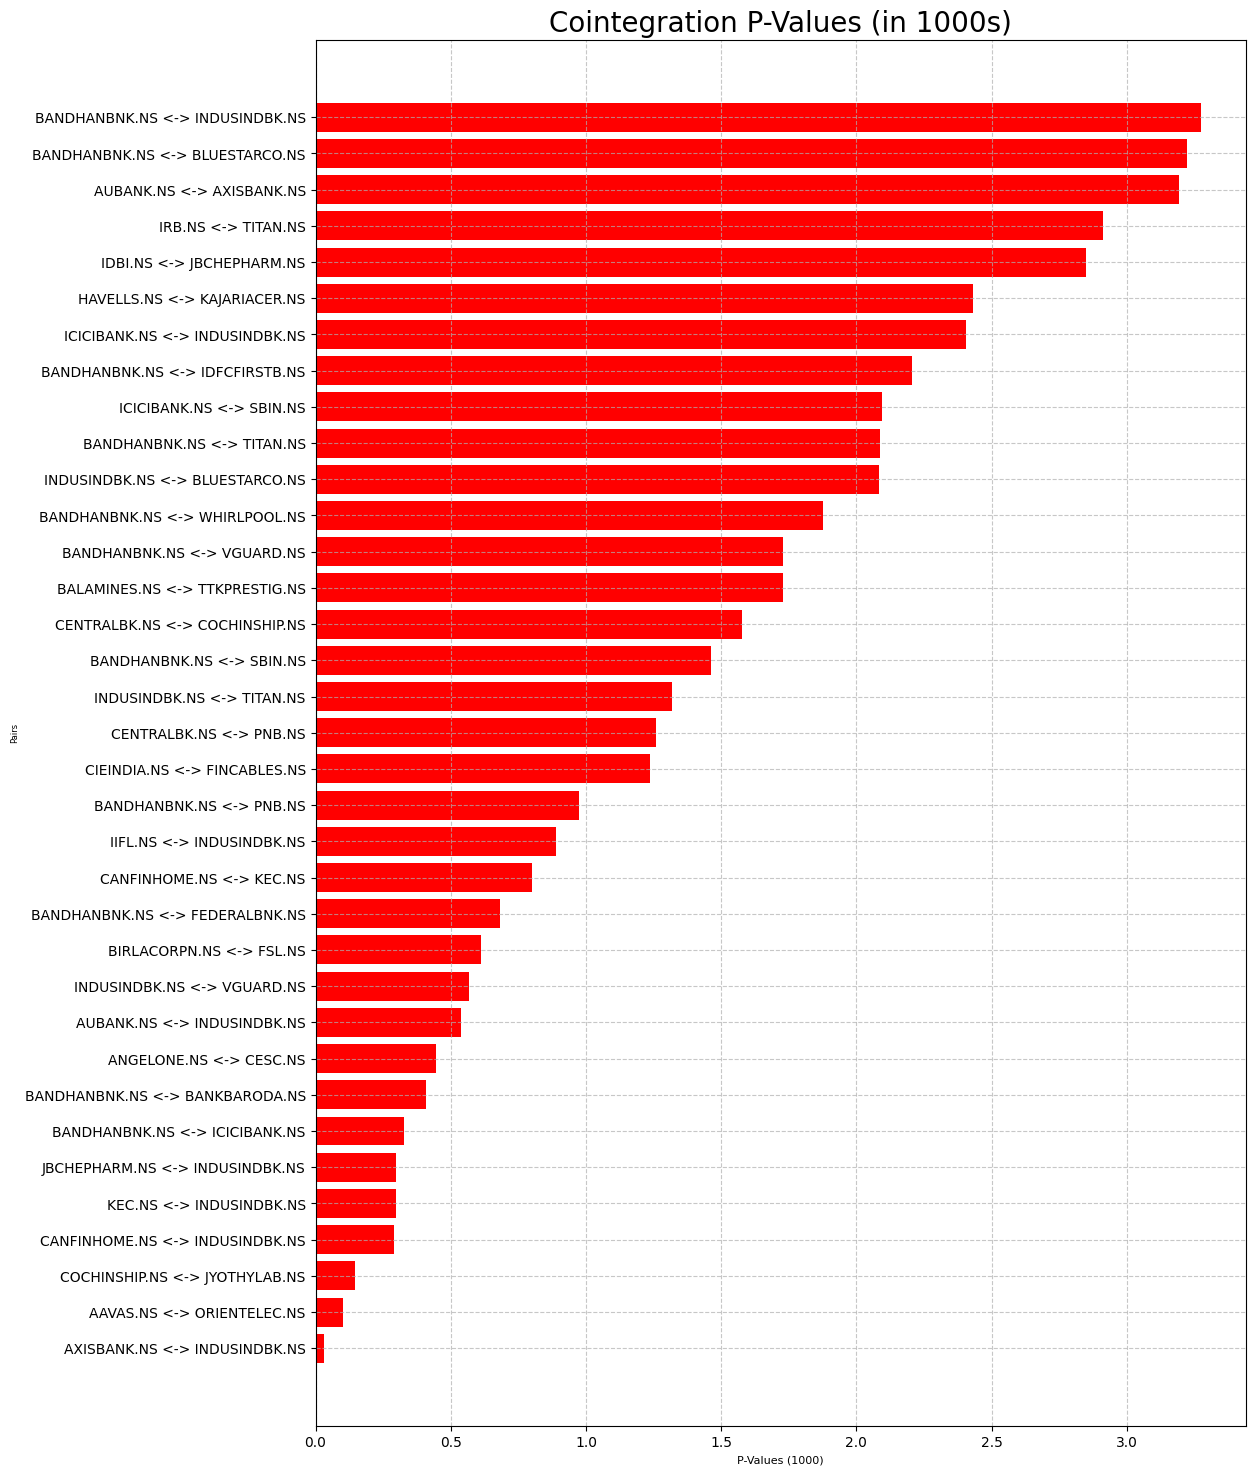

In [46]:
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sorted_pairs = sorted_pairs[0:35]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sorted_pairs])

plt.figure(figsize=(12, 18))
plt.barh(sorted_pairs_labels,
         pairs_p_values, color='red')
plt.xlabel('P-Values (1000)', fontsize=8)
plt.ylabel('Pairs', fontsize=6)
plt.title('Cointegration P-Values (in 1000s)', fontsize=20)

plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

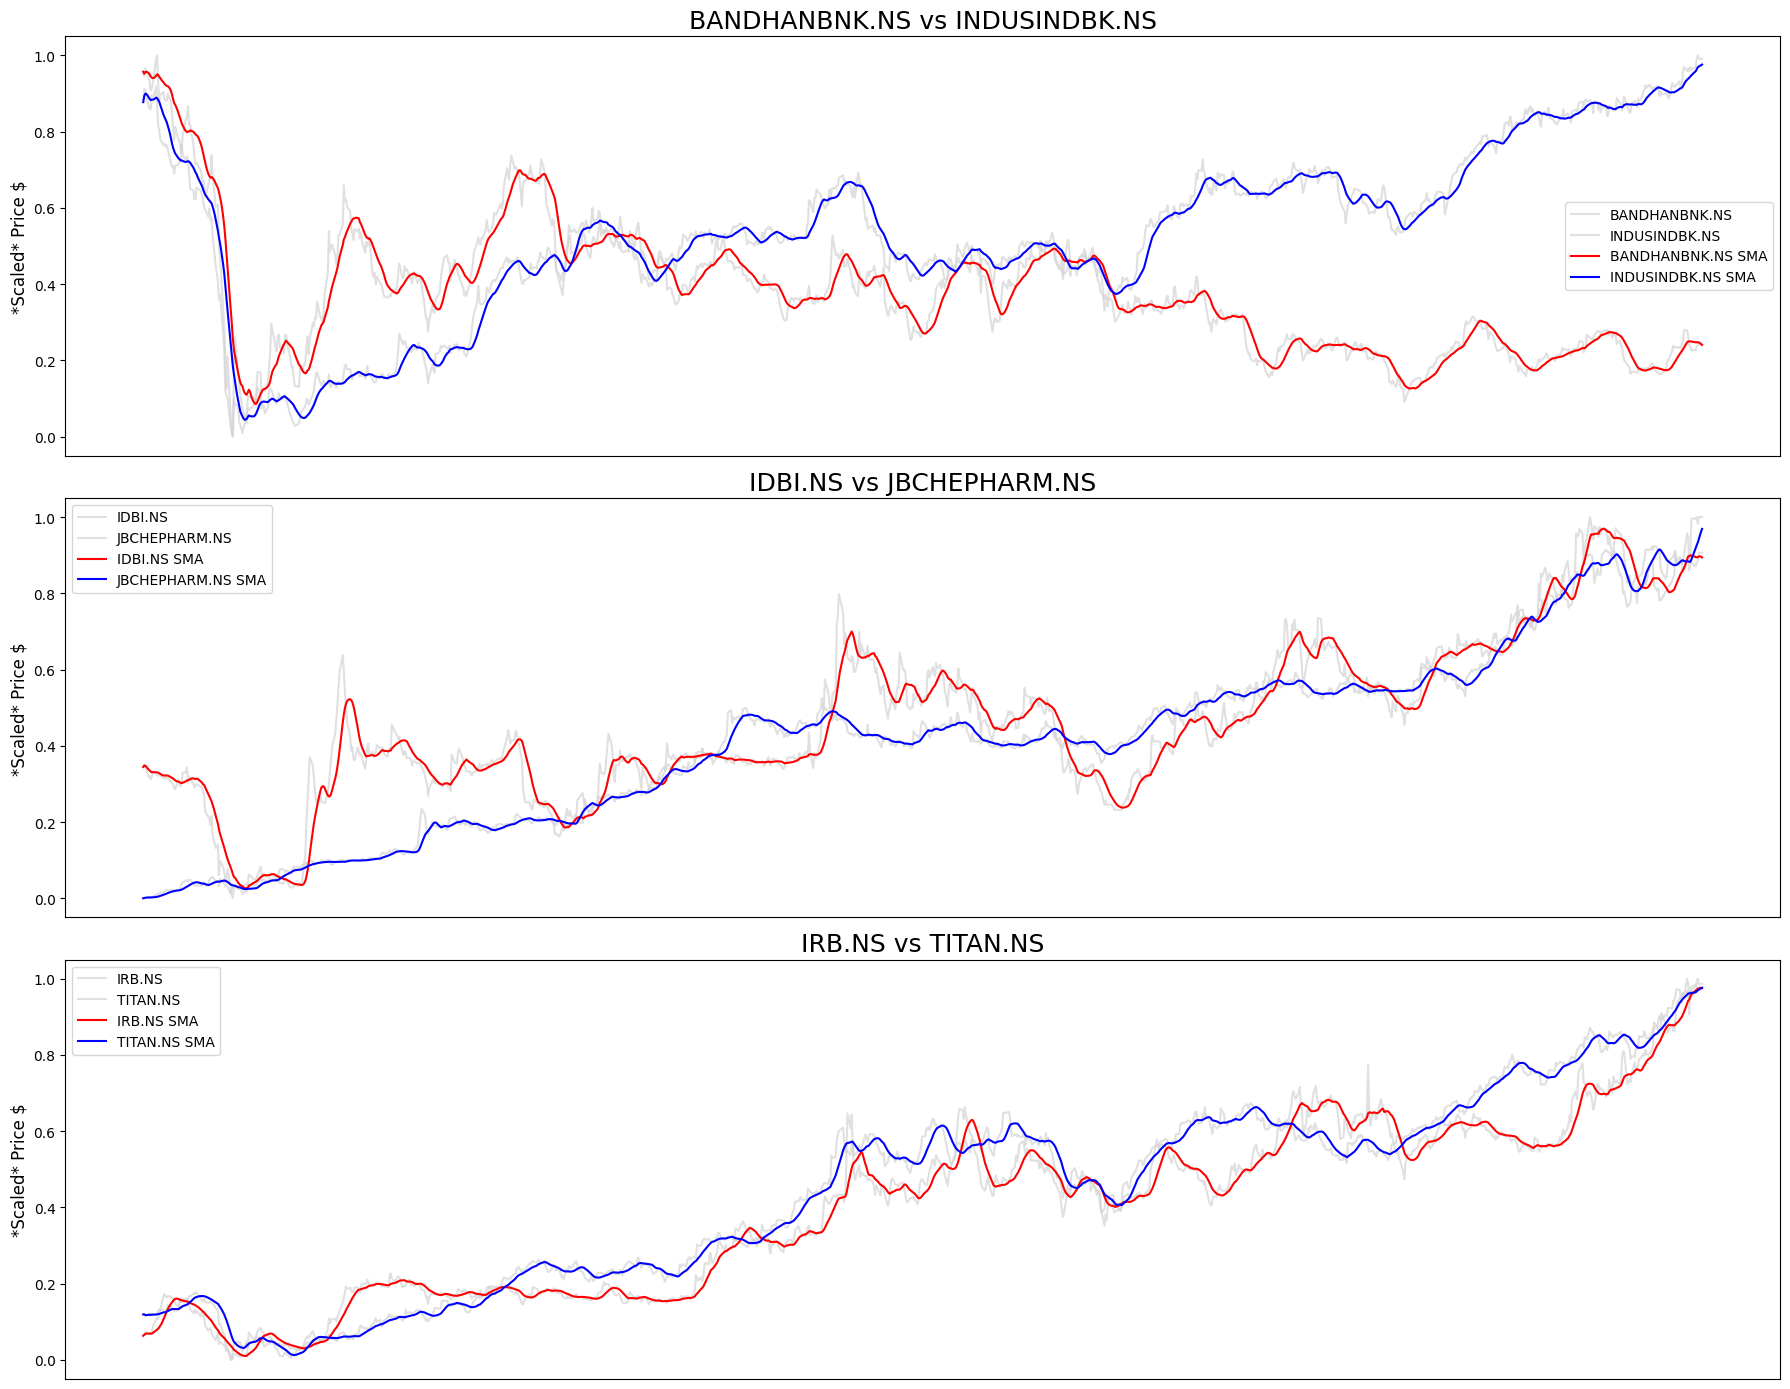

In [49]:
from sklearn.preprocessing import MinMaxScaler

ticker_pairs = [("BANDHANBNK.NS", "INDUSINDBK.NS"), ("IDBI.NS", "JBCHEPHARM.NS"), ("IRB.NS", "TITAN.NS")]

fig, axs = plt.subplots(3, 1, figsize=(18, 14))
scaler = MinMaxScaler()

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        uts_sanitized[ticker1]['Adj Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        uts_sanitized[ticker2]['Adj Close'].values.reshape(-1, 1))

    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)

    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()

    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')

    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

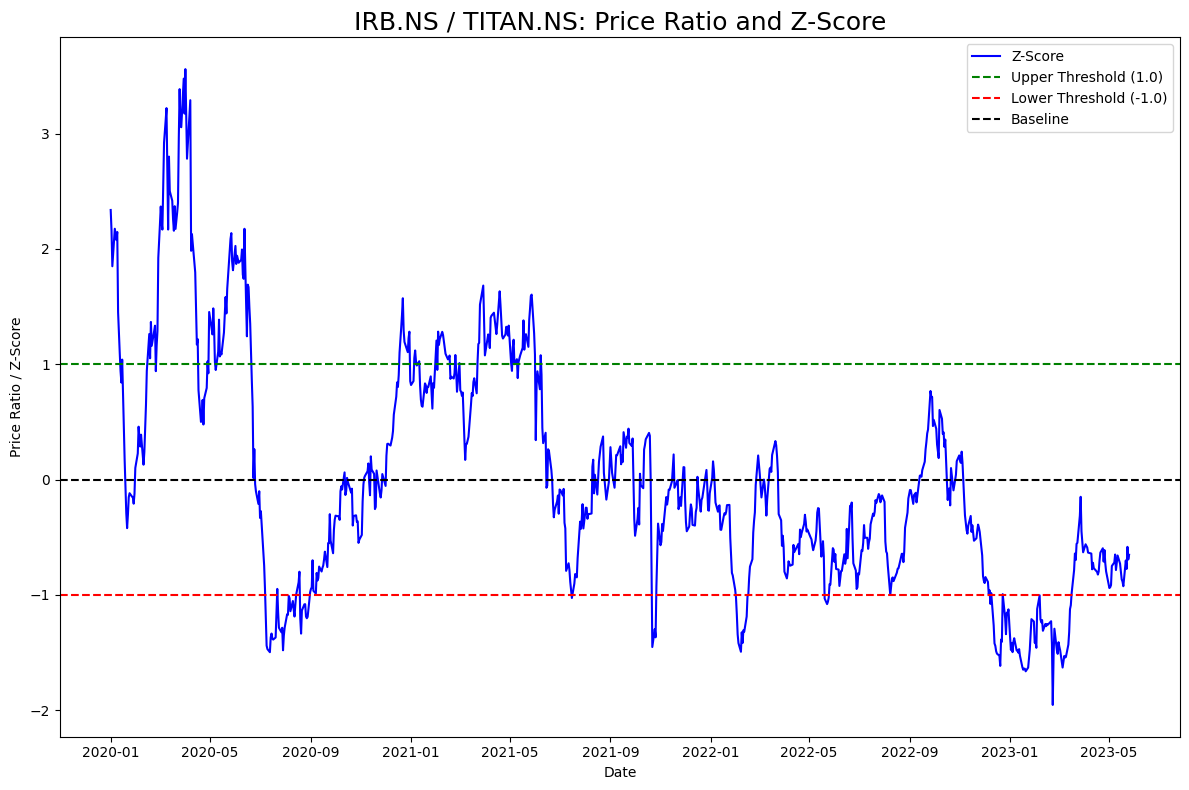

In [59]:
TRAIN = int(len(uts_sanitized["IRB.NS"]) * 0.85)
TEST = len(uts_sanitized["TITAN.NS"]) - TRAIN


AAVE_ts = uts_sanitized["IRB.NS"]["Adj Close"][:TRAIN]
C_ts = uts_sanitized["TITAN.NS"]["Adj Close"][:TRAIN]

# Calculate price ratio (AAVE-USD price / C price)
ratios = C_ts/AAVE_ts
fig, ax = plt.subplots(figsize=(12, 8))

ratios_mean = np.mean(ratios)
ratios_std = np.std(ratios)
ratios_zscore = (ratios - ratios_mean) / ratios_std

ax.plot(ratios.index, ratios_zscore, label="Z-Score", color='blue')

# Plot reference lines
ax.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
ax.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
ax.axhline(0, color="black", linestyle='--', label="Baseline")

ax.set_title('IRB.NS / TITAN.NS: Price Ratio and Z-Score', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Price Ratio / Z-Score')
ax.legend()
plt.tight_layout()
plt.show()

<Figure size 2600x1800 with 0 Axes>

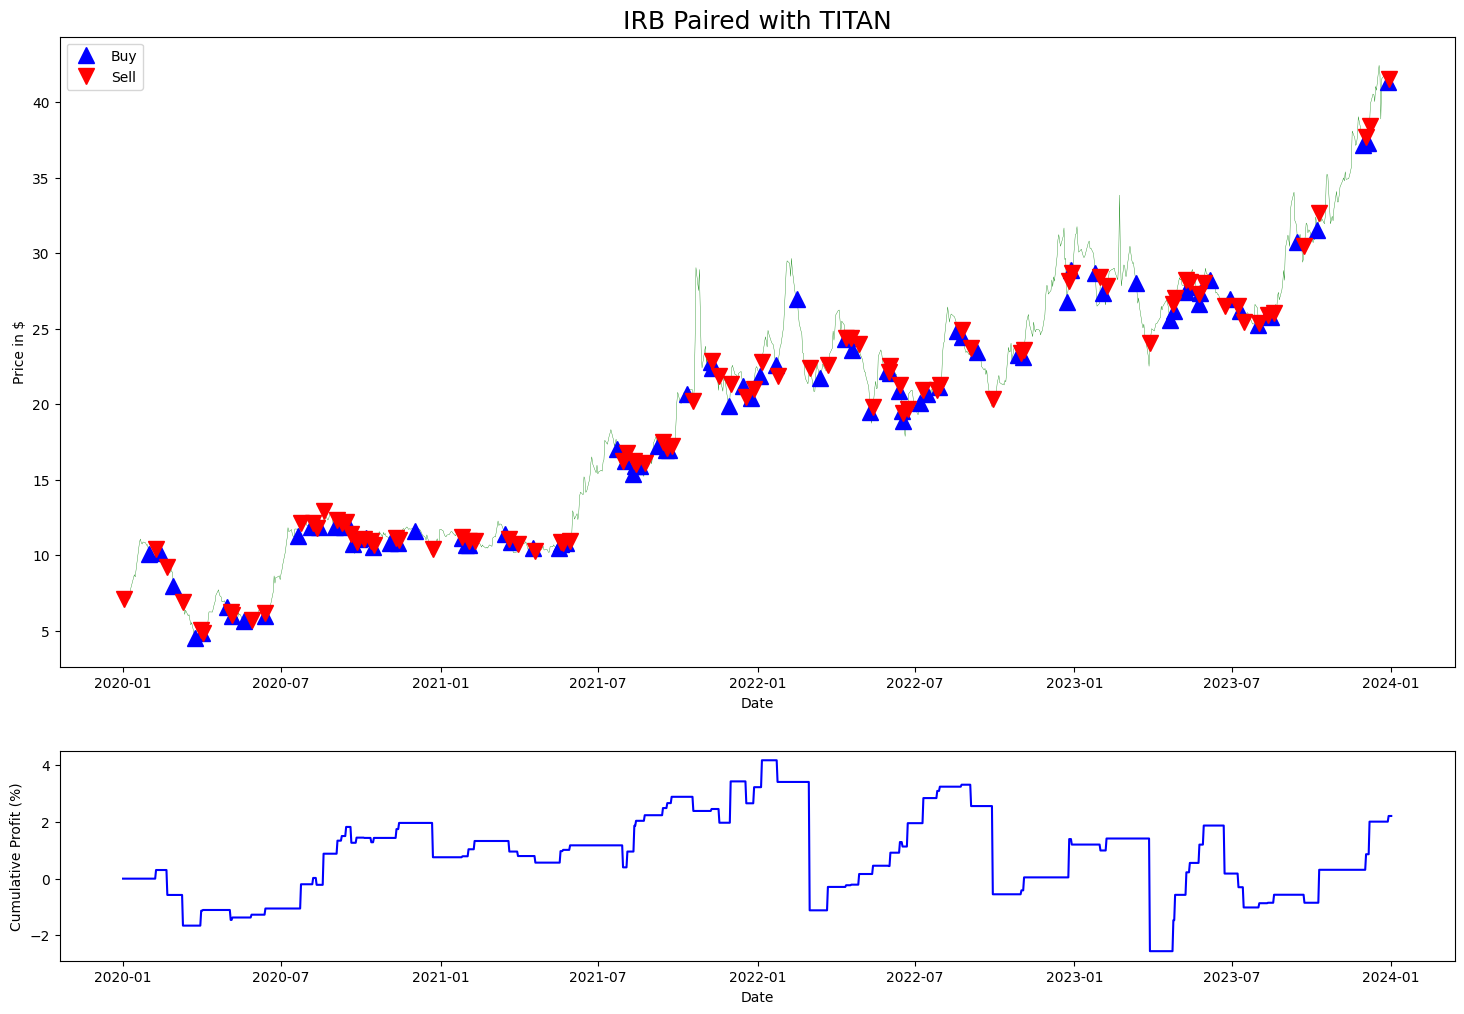

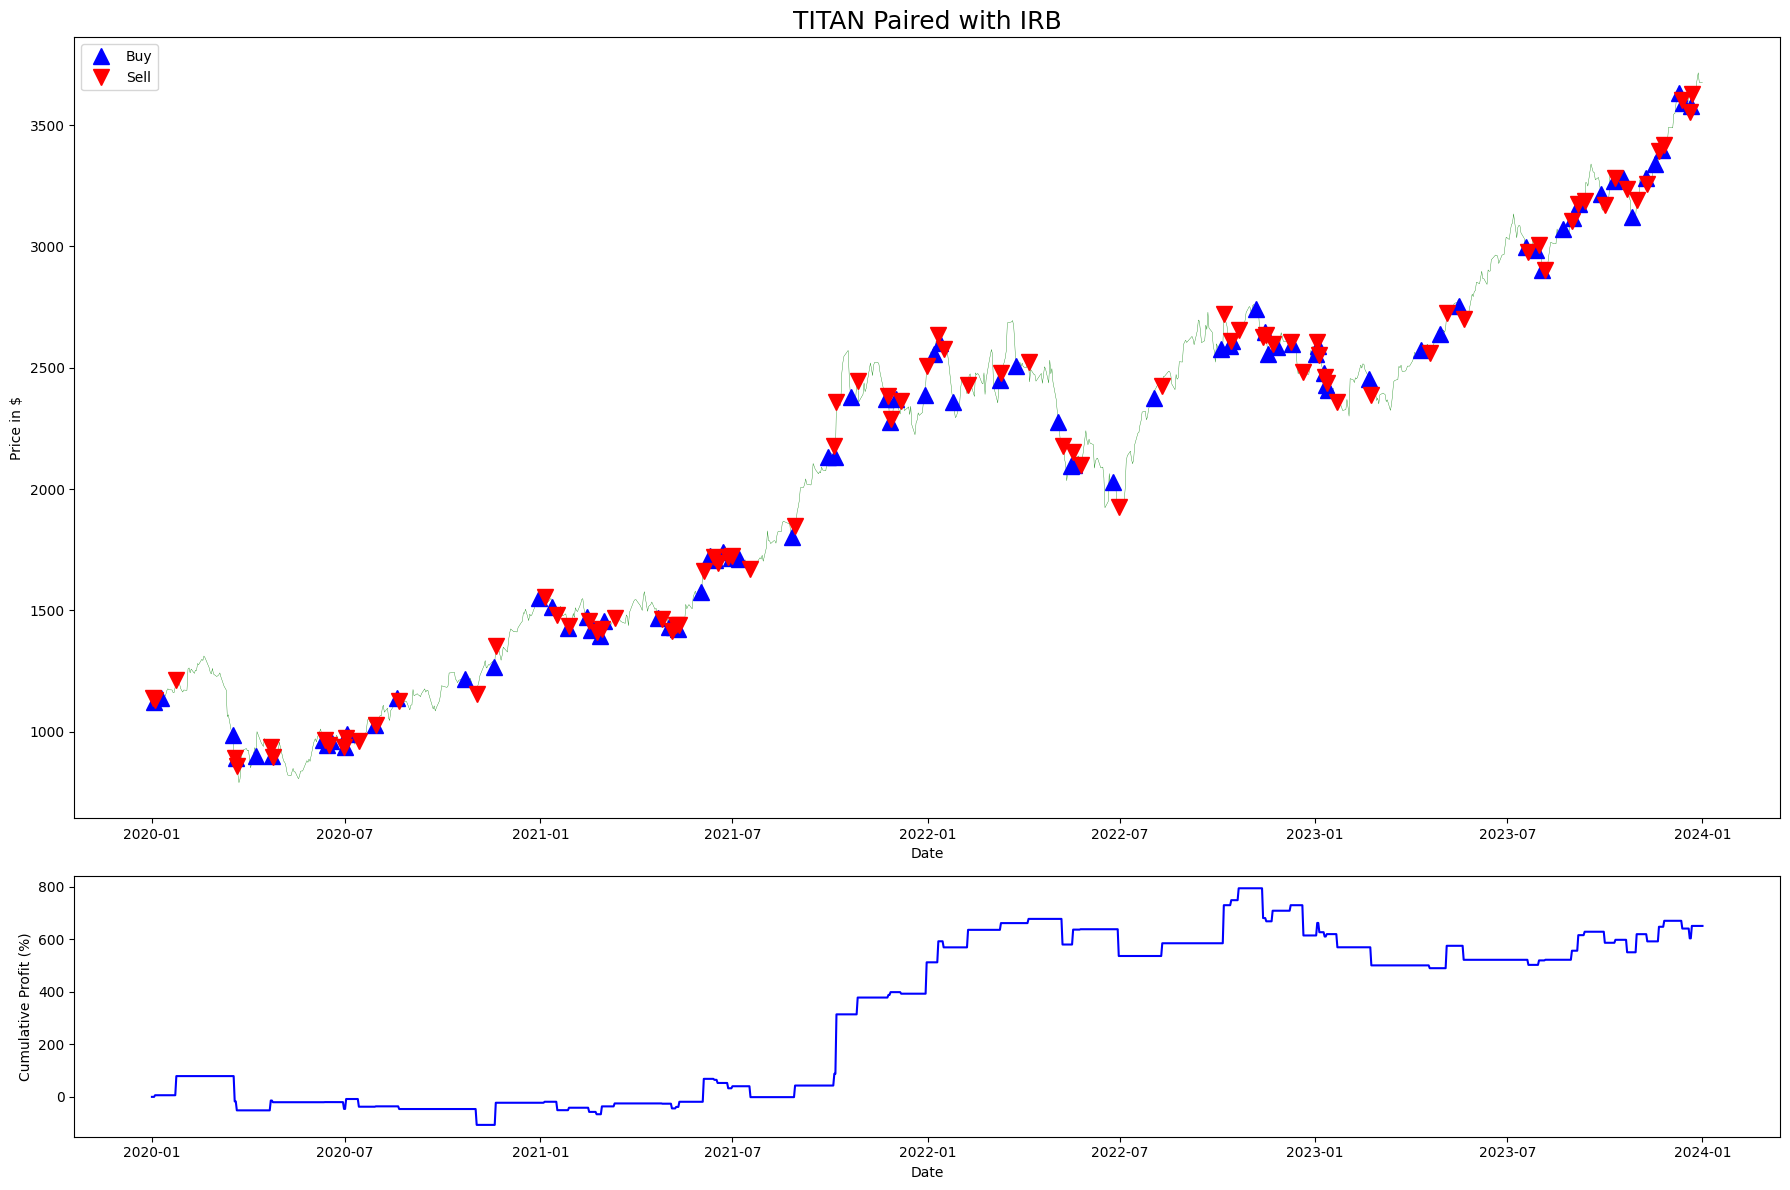

In [60]:
def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.
    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.

    Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.

    """
    ratios = ticker1_ts / ticker2_ts

    ratios_mean = ratios.rolling(
        window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(
        window=window_size, min_periods=1, center=False).std()

    z_scores = (ratios - ratios_mean) / ratios_std

    buy = ratios.copy()
    sell = ratios.copy()

    if first_ticker:
        # These are empty zones, where there should be no signal
        # the rest is signalled by the ratio.
        buy[z_scores > -1] = 0
        sell[z_scores < 1] = 0
    else:
        buy[z_scores < 1] = 0
        sell[z_scores > -1] = 0

    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = np.where(buy > 0, 1, np.where(sell < 0, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df

AAVE_ts = uts_sanitized["IRB.NS"]["Adj Close"]
C_ts = uts_sanitized["TITAN.NS"]["Adj Close"]

plt.figure(figsize=(26, 18))
signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
ax1, _ = plot_strategy(AAVE_ts, signals_df1, profit_df1)

signals_df2 = signals_zscore_evolution(AAVE_ts, C_ts, first_ticker=False)
profit_df2 = calculate_profit(signals_df2, C_ts)
ax2, _ = plot_strategy(C_ts, signals_df2, profit_df2)

ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f'IRB Paired with TITAN', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f'TITAN Paired with IRB', fontsize=18)
plt.tight_layout()
plt.show()

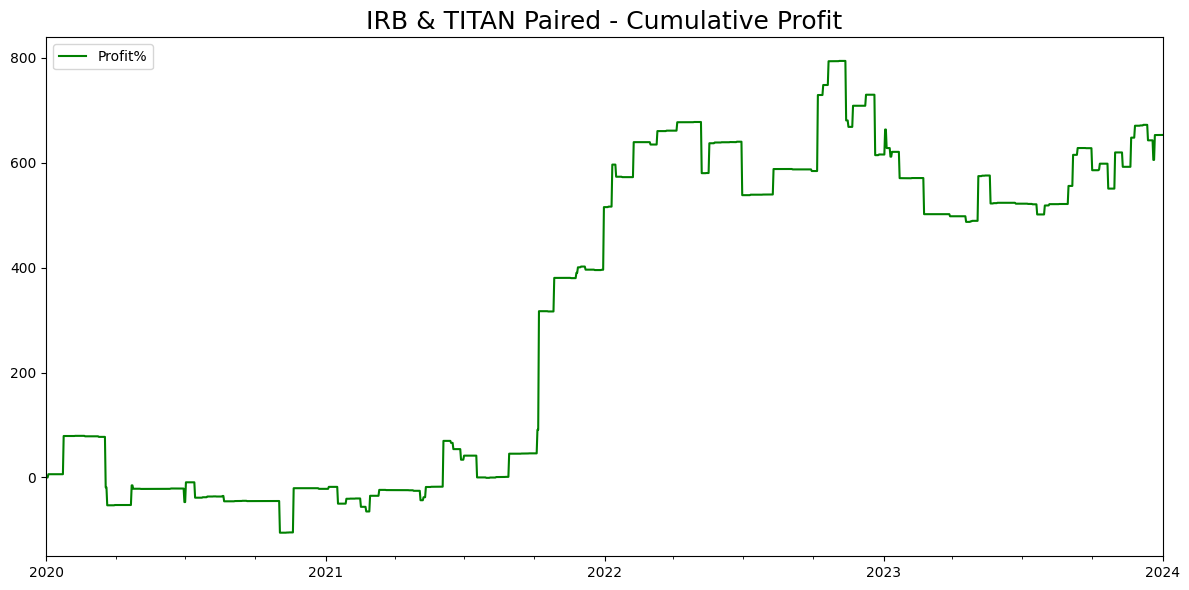

In [61]:
plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'IRB & TITAN Paired - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()